In [1]:
# Lab 3 - Kun Lee, partner: Lexie Peterson
#Setup
%matplotlib inline
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import scipy
import scipy.signal
from scipy import stats

#this sets the size of the plot to something useful
plt.rcParams["figure.figsize"] = (20,15)

d = stats.norm.rvs(loc = 5., scale = 0.01, size = 100000)

fig, ax = plt.subplots(1, 1)
plt.xlim(0,10)

y = np.linspace(0,9,10)
y2 = np.linspace(0,18,19)

base = scipy.stats.poisson.pmf(y,2)
base2 = scipy.signal.convolve(base,base)
ax.bar(y,base)
plt.show()

Start by simulating 100k 'good' data points assuming Gaussian fluctations, and because we are playing god adding the following 'bad' datapoints: {10., 10.3, 2.1, 0., 0., 15.6, 22.3, 12.7}

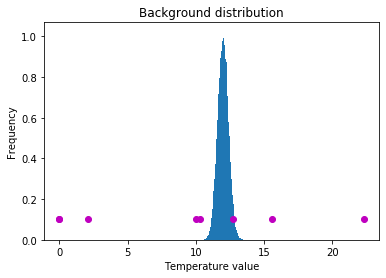

In [20]:
good_data = scipy.stats.norm.rvs(loc=12,scale=0.4,size=100000)
bad_data = [10.,10.3,2.1,0.,0.,15.6,22.3,12.7]
data = np.append(good_data, bad_data)
y = np.linspace(0,100000,100000)
fig, ax = plt.subplots(1, 1)
#plt.xlim(0,100000)
ax.hist(data, bins=1001,density=True)
ax.set_title("Background distribution")
ax.set_xlabel("Temperature value")
ax.set_ylabel("Frequency")
for point in bad_data:
    ax.plot(point,0.1,'mo')
plt.show()

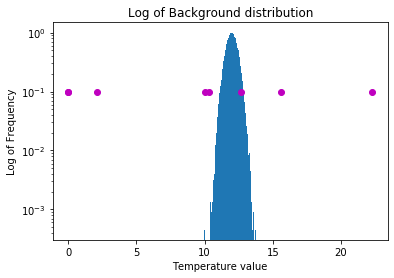

In [19]:
fig, ax = plt.subplots(1, 1)
#plt.xlim(0,100000)
ax.hist(data, bins=1001,density=True)
ax.set_title("Log of Background distribution")
ax.set_xlabel("Temperature value")
ax.set_ylabel("Log of Frequency")
ax.set_yscale("log")
for point in bad_data:
    ax.plot(point,0.1,'mo')
plt.show()

State the statistical question in words. Be very clear, and describe why you have chosen this statistical question:

The question is how can we pick a test that will allow us to distinguish between good data and bad data? 

Restate your question in math. Be very clear:

Given that the good data follows a Gaussian distribution, what sigma level can we choose such that points with a z-score greater than that level gets rejected? Can we choose a level such that all known bad points are rejected but all known good points are not? Given that 99.7 of values in a normally distributed set of data falls within 3 standard deviations, I think rejecting points more than 5 standard deviations away from the mean is a good start. But we can do better...

Since we know we have 8 bad and 100k good data points, that's a probability of 8/100008 of getting a bad data point. What sigma value is that (i.e. what x-value does that correspond to?)

In [21]:
p = 8/100008
scipy.stats.norm.isf(p)

3.7750318807261567

The interpretation of this is: if we integrate from right to left on a standard normal distribution, when we reach an area under the curve of 3.775, we are at x=3.77. So the sigma value is 3.77 since the SND had a standard deviation of 1. Now let's apply this to our nonstandard normal distribution.

In [22]:
scipy.stats.norm.isf(p,loc=12,scale=0.4)

13.510012752290463

Values greater than 13.51 and less than 10.49 are outside of our 3.77 sigma significance level (i.e. 1-cdf(13.51) is p = 8/100008).

In [32]:
scipy.stats.norm.ppf(p,loc=12,scale=0.4)

10.489987247709537

So our question becomes: If we take points with a sigma value greater than 3.77 to be false, how accurately can we remove actual bad data?

Apply your statistical test and construct a truth table.

In [38]:
truepos = 0
trueneg = 0
falsepos = 0
falseneg = 0
high = scipy.stats.norm.isf(p,loc=12,scale=0.4)
low = scipy.stats.norm.ppf(p,loc=12,scale=0.4)
for point in good_data:
    if point > high or point < low:
        trueneg = trueneg + 1
    else:
        truepos = truepos + 1

for point in bad_data:
    if point > high or point < low:
        falseneg = falseneg + 1
    else:
        falsepos = falsepos + 1

from tabulate import tabulate as tb
print(tb([["Positive",truepos,falsepos],["Negative", trueneg,falseneg]],headers=["true","false"]))

            true    false
--------  ------  -------
Positive   99986        1
Negative      14        7


B) How does the number of omissions, where you threw out good data, depend on the statistical threshold you chose and is it a predictable quantity?

Yes, it depends on the sigma we choose. If we choose a higher sigma we throw out less good data but accept more bad data and vice versa. Let's explore this by running the test again with a higher sigma of 5 sigma:

In [39]:
truepos = 0
trueneg = 0
falsepos = 0
falseneg = 0
p = scipy.stats.norm.sf(5)
high = scipy.stats.norm.isf(p,loc=12,scale=0.4)
low = scipy.stats.norm.ppf(p,loc=12,scale=0.4)
for point in good_data:
    if point > high or point < low:
        trueneg = trueneg + 1
    else:
        truepos = truepos + 1

for point in bad_data:
    if point > high or point < low:
        falseneg = falseneg + 1
    else:
        falsepos = falsepos + 1

from tabulate import tabulate as tb
print(tb([["Positive",truepos,falsepos],["Negative", trueneg,falseneg]],headers=["true","false"]))

            true    false
--------  ------  -------
Positive  100000        3
Negative       0        5


When we do it with a 5 sigma level we don't commit any mistakes of omission (throwing out good data) but we do have more false positives (mistakes of commision, bad data getting in). Can we predict how much bad data we throw out? Because the good data is normally distributed, we can calculate how much good data we expect to have an x-value greater than our threshold (the sigma level we chose). I.e. p(x > threshold) * number of data points = number of mistakes of omission.

In [50]:
scipy.stats.norm.sf(3.77) * 100000
#scipy.stats.norm.sf(5) * 100000

8.162377370268604

C) Are there mistakes of commission (bad data getting in)? If yes, are they avoidable and how do they depend on your statistical threshold?

Yes. With our 3.77 sigma level, we have 1 mistake of commision. If we reduce our sigma level, we can probably reduce that number since we're essentially being more strict and only accepting points closer to the mean. Let's try this with 2 sigma:

In [42]:
truepos = 0
trueneg = 0
falsepos = 0
falseneg = 0
p = scipy.stats.norm.sf(2)
high = scipy.stats.norm.isf(p,loc=12,scale=0.4)
low = scipy.stats.norm.ppf(p,loc=12,scale=0.4)
for point in good_data:
    if point > high or point < low:
        trueneg = trueneg + 1
    else:
        truepos = truepos + 1

for point in bad_data:
    if point > high or point < low:
        falseneg = falseneg + 1
    else:
        falsepos = falsepos + 1

from tabulate import tabulate as tb
print(tb([["Positive",truepos,falsepos],["Negative", trueneg,falseneg]],headers=["true","false"]))

            true    false
--------  ------  -------
Positive   95568        1
Negative    4432        7


We didn't manage to avoid that mistake, it seems. Looking at the set of data points, it appears that there's a bad data point of 12.7, which is less than 2 standard deviations away. Running the test again with sigma = 1 would probably fix this.

In [43]:
scipy.stats.norm.sf(5) # SND 5 sigma probability

2.8665157187919333e-07

In [45]:
1/3500000 #1 in 3.5 million

2.857142857142857e-07

In [46]:
# mean + 5(0.4)
scipy.stats.norm.sf(14,loc=12,scale=0.4)

2.8665157187919333e-07

In [47]:
# mean + 5(2)
scipy.stats.norm.sf(10,scale=2)

2.8665157187919333e-07

The examples above illustrate why we chose 12 plus minus 2 for our 5 sigma example.

Question 2:

The question in words: If we have a 2d Gaussian with a 1 arcsecond RMS, what is the distribution associated with the distance traveled from the center?

The question in math: What distribution characterizes a distribution that is formed when we have 2 standard normal distributions representing the X and Y axes and the distribution is made up of the length sqrt(x^2 + y^2)?

The answer from Wikipedia:
A Rayleigh distribution is often observed when the overall magnitude of a vector is related to its directional components. One example where the Rayleigh distribution naturally arises is when wind velocity is analyzed in two dimensions. Assuming that each component is uncorrelated, normally distributed with equal variance, and zero mean, then the overall wind speed (vector magnitude) will be characterized by a Rayleigh distribution.
R ~ Rayleigh(sigma) is Rayleigh distributed if X ~ N(0,sigma squared) and Y ~ N(0,sigma squared) are independent normal random variables.[6] (This gives motivation to the use of the symbol "sigma" in the above parametrization of the Rayleigh density.)

What is the 5 sigma distance in arcseconds?

In [12]:
# sigma squared = 1 so sigma = 1.
import scipy.stats
p = scipy.stats.norm.sf(5) # 1 in 3.5 million
scipy.stats.rayleigh.isf(p)

5.489079776062419

Problem 3:
    
The question in words: What is the chance of seeing 6800 rays or less in 15 days given the background rate of rays in the question?

Translate to math: From the question, "Assume a moon sized patch on the sky we normally have a cosmic ray rate of 1 cosmic ray per minute (arrivals are random in time).". This suggests a Poisson distribution since we have a background rate and cosmic rays are independent events. The question is: with the background Poisson distribution, what is the probability of seeing 6800 events or less, in terms of a "sigma" level which is that probability expressed in terms of standard deviations on the standard normal distribution?

Our background distribution: 15 days * 8 hours/day * 1 ray/min = 7200 rays. 

In [5]:
scipy.stats.norm.ppf(scipy.stats.poisson.cdf(6800,7200))

-4.750747965777188

Sigma of 4.5.

There are some unique aspects to this problem. Make sure you explore them in your explanation.
The poisson distribution assumes that the rate of the events are constant and independent. I'm guessing that the unique aspect is that this may not be an accurate way to model the ray distribution. For example, because the moon is in different positions throughout the night, the rate at which it blocks the rays might change.